<a href="https://colab.research.google.com/github/111DataScienceWizard/TREBIRTH/blob/main/Collab%20Notes/MultiClass_Classification_SKLearn_models_in_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Necessary Tools**

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 26.7 MB/s eta 0:00:00


In [ ]:
!pip install skl2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 5.4 MB/s eta 0:00:00


**Importing necessary libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort
from tf2onnx import convert
from tensorflow import keras

**Feature Extraction using Rolling Statistic Extractotor**

In [ ]:
class RollingStatisticsExtractor:
    def __init__(self, window_size):
        self.window_size = window_size

    def fit(self, data):
        self.data = data
        return self

    def transform(self, data):
        rolling_statistics = data.rolling(window=self.window_size, min_periods=5)
        aggregated_features = pd.DataFrame()

        for column in data.columns:
            aggregated_features[f'{column}_mean'] = rolling_statistics[column].mean()
            aggregated_features[f'{column}_median'] = rolling_statistics[column].median()
            aggregated_features[f'{column}_std'] = rolling_statistics[column].std()
            aggregated_features[f'{column}_rms'] = rolling_statistics[column].apply(lambda x: np.sqrt(np.mean(x ** 2)))
            aggregated_features[f'{column}_peak2peak'] = rolling_statistics[column].max() - rolling_statistics[column].min()

        aggregated_features = aggregated_features.dropna()
        return aggregated_features

    def fit_transform(self, data):
        return self.fit(data).transform(data)


Defining Function to Load the data and give labels to the data

In [ ]:
def add_labels(df, label):
    df['label'] = label
    return df

**Defining function to only keep Raw and Lpf columns in all the loaded data**

In [ ]:
def preprocess_data(data):
    columns_to_keep = ['Raw', 'LPF']
    return data[columns_to_keep]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Healthy data**

In [ ]:
healthy_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh1.xlsx'), 'healthy')
healthy_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/sh2.xlsx'), 'healthy')
healthy_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh3.xlsx'), 'healthy')
healthy_data_4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh4.xlsx'), 'healthy')

**Loading Fast movement and small movement data**

In [ ]:
infected_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm1.xlsx'), 'fast_movement')
infected_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm2.xlsx'), 'fast_movement')
infected_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm3.xlsx'), 'fast_movement')
infected_data_4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm4.xlsx'), 'fast_movement')
infected_data_9 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm1.xlsx'), 'small_movement')
infected_data_10 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm2.xlsx'), 'small_movement')
infected_data_11 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm3.xlsx'), 'small_movement')
infected_data_12 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm4.xlsx'), 'small_movement')

**Concatenating data according to their respective categories**

In [ ]:
healthy_data = pd.concat([healthy_data_1, healthy_data_2, healthy_data_3, healthy_data_4])
fast_movement= pd.concat([infected_data_1, infected_data_2, infected_data_3, infected_data_4])
small_movement= pd.concat([infected_data_9, infected_data_10, infected_data_11, infected_data_12])

**Preprocessing the data**

In [ ]:
healthy_data = preprocess_data(healthy_data)
fast_movement = preprocess_data(fast_movement)
small_movement = preprocess_data(small_movement)

**Giving window size**

In [ ]:
window_size = 500
extractor = RollingStatisticsExtractor(window_size)

In [ ]:
numeric_columns1 = healthy_data.select_dtypes(include=np.number).columns
numeric_columns2 = fast_movement.select_dtypes(include=np.number).columns
numeric_columns3 = small_movement.select_dtypes(include=np.number).columns

**Extracting the features using the function**

In [ ]:
healthy_aggregated_features = extractor.fit_transform(healthy_data[numeric_columns1])
fast_aggregated_features = extractor.fit_transform(fast_movement[numeric_columns2])
small_aggregated_features = extractor.fit_transform(small_movement[numeric_columns3])


In [ ]:
print(healthy_aggregated_features.isnull().sum())

Raw_mean         0
Raw_median       0
Raw_std          0
Raw_rms          0
Raw_peak2peak    0
LPF_mean         0
LPF_median       0
LPF_std          0
LPF_rms          0
LPF_peak2peak    0
dtype: int64


**Reset the index**

In [ ]:
healthy_data_reset = healthy_data.reset_index(drop=True)
fast_movement_reset = fast_movement.reset_index(drop=True)
small_movement_reset = small_movement.reset_index(drop=True)

In [ ]:
healthy_aggregated_features_reset = healthy_aggregated_features.reset_index(drop=True)
fast_aggregated_features_reset = fast_aggregated_features.reset_index(drop=True)
small_aggregated_features_reset = small_aggregated_features.reset_index(drop=True)

**Concatenating the extracted features with the actual data**

In [ ]:
healthy_data_with_features = pd.concat([healthy_data_reset, healthy_aggregated_features_reset], axis=1)
fast_data_with_features = pd.concat([fast_movement_reset, fast_aggregated_features_reset], axis=1)
small_data_with_features = pd.concat([small_movement_reset, small_aggregated_features_reset], axis=1)

In [ ]:
print("\nSmall Movement Data with Features:")
print(small_data_with_features.head())


Small Movement Data with Features:
    Raw      LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  2048  2063.15  2043.000000      2048.0  10.099505  2043.019971   
1  2048  2060.30  2042.666667      2047.0   9.070097  2042.683447   
2  2046  2053.84  2045.285714      2048.0  10.796825  2045.310141   
3  2025  2044.38  2046.625000      2048.0  10.689614  2046.649427   
4  2048  2033.33  2047.333333      2048.0  10.222524  2047.356019   

   Raw_peak2peak     LPF_mean  LPF_median    LPF_std      LPF_rms  \
0           23.0  2051.000000    2053.840  12.229385  2051.029168   
1           23.0  2046.278333    2049.110  15.918891  2046.329933   
2           36.0  2041.752857    2044.380  18.829112  2041.827274   
3           36.0  2037.901250    2038.855  20.556424  2037.991965   
4           36.0  2035.106667    2033.330  20.976964  2035.202763   

   LPF_peak2peak  
0          29.82  
1          40.48  
2          48.55  
3          52.21  
4          52.21  


**EDA PROCESS OF HEALTHY DATA**

In [ ]:
healthy_data_with_features.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,2046,2042.161624,2049.200000,2048.0,3.563706,2049.202479,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0
1,2048,2042.161624,2049.333333,2049.0,3.204164,2049.335421,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0
2,2055,2042.161624,2047.714286,2048.0,5.186980,2047.719917,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0
3,2050,2042.161624,2047.250000,2047.5,4.978525,2047.255297,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0
4,2047,2042.161624,2046.333333,2047.0,5.408327,2046.339686,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0


In [ ]:
healthy_data_with_features.shape

(15913, 12)

In [ ]:
healthy_data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15913 entries, 0 to 15912
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            15913 non-null  int64  
 1   LPF            15913 non-null  float64
 2   Raw_mean       15909 non-null  float64
 3   Raw_median     15909 non-null  float64
 4   Raw_std        15909 non-null  float64
 5   Raw_rms        15909 non-null  float64
 6   Raw_peak2peak  15909 non-null  float64
 7   LPF_mean       15909 non-null  float64
 8   LPF_median     15909 non-null  float64
 9   LPF_std        15909 non-null  float64
 10  LPF_rms        15909 non-null  float64
 11  LPF_peak2peak  15909 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB


In [ ]:
healthy_data_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
healthy_data_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
healthy_data_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
healthy_data_with_features_cleaned = healthy_data_with_features.dropna()

In [ ]:
print(healthy_data_with_features_cleaned.head())

    Raw          LPF     Raw_mean  Raw_median   Raw_std      Raw_rms  \
0  2046  2042.161624  2049.200000      2048.0  3.563706  2049.202479   
1  2048  2042.161624  2049.333333      2049.0  3.204164  2049.335421   
2  2055  2042.161624  2047.714286      2048.0  5.186980  2047.719917   
3  2050  2042.161624  2047.250000      2047.5  4.978525  2047.255297   
4  2047  2042.161624  2046.333333      2047.0  5.408327  2046.339686   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0            9.0  2042.161624  2042.161624      0.0  2042.161624   
1            9.0  2042.161624  2042.161624      0.0  2042.161624   
2           17.0  2042.161624  2042.161624      0.0  2042.161624   
3           17.0  2042.161624  2042.161624      0.0  2042.161624   
4           17.0  2042.161624  2042.161624      0.0  2042.161624   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
for i in healthy_data_with_features.columns:
    print(i)
    print(healthy_data_with_features[i].nunique())
    print(healthy_data_with_features[i].unique())

Raw
318
[2046 2048 2055 2050 2047 2038 2044 2039 2040 2043 2042 2034 2032 2059
 2045 2037 2029 2049 2056 2035 2057 2036 2053 2060 2051 2041 2052 2031
 2054 2033 2061 2064 2027 2028 2030 2058 2025 2067 2063 2023 2062 2021
 2026 2069 2065 2066 2022 2072 2012 2014 2016 2088 2082 2083 2013 2017
 2086 2077 2024 2070 2008 2000 1996 2079 2101 2097 2107 2099 2094 2098
 2091 1997 2010 2020 2009 2005 1982 1991 2073 2071 2080 2074 2081 2087
 2105 2102 2075 2076 2085 2019 1892 1673 1370 1122 1038 1204 1681 2555
 3375 3599 3275 2650 2104 1652 1318 1033  765  381    0  582 3500 4074
 4030 4075 4050 4071 4031 3866 3357 2724 2142 1565 1058  656  322   60
    8  441 1372 2432 3311 3864 4018 3967 3682 3232 2763 2239 1755 1328
  994  709  518  565 1018 1745 2435 2942 3223 3288 3149 2905 2575 2235
 1888 1568 1298 1119 1092 1359 1788 2224 2528 2698 2687 2577 2388 2157
 1948 1769 1641 1670 1822 2202 2271 2264 2182 2018 2093 2178 2244 2270
 2269 2263 2227 2183 2110 1928 2096 2068 2004 2090 2084 1960 1938 195

**EDA OF FAST MOVEMENT**

In [ ]:
fast_data_with_features.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,2030,2042.843147,2031.800000,2030.0,5.585696,2031.806142,15.0,2042.843147,2042.843147,0.0,2042.843147,0.0
1,2041,2042.843147,2032.000000,2031.0,5.019960,2032.005167,15.0,2042.843147,2042.843147,0.0,2042.843147,0.0
2,2026,2042.843147,2034.857143,2032.0,8.839845,2034.873601,26.0,2042.843147,2042.843147,0.0,2042.843147,0.0
3,2030,2042.843147,2038.500000,2032.5,13.158376,2038.537159,38.0,2042.843147,2042.843147,0.0,2042.843147,0.0
4,2032,2042.843147,2040.888889,2033.0,14.242932,2040.933065,38.0,2042.843147,2042.843147,0.0,2042.843147,0.0


In [ ]:
fast_data_with_features.shape

(16161, 12)

In [ ]:
fast_data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16161 entries, 0 to 16160
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            16161 non-null  int64  
 1   LPF            16161 non-null  float64
 2   Raw_mean       16157 non-null  float64
 3   Raw_median     16157 non-null  float64
 4   Raw_std        16157 non-null  float64
 5   Raw_rms        16157 non-null  float64
 6   Raw_peak2peak  16157 non-null  float64
 7   LPF_mean       16157 non-null  float64
 8   LPF_median     16157 non-null  float64
 9   LPF_std        16157 non-null  float64
 10  LPF_rms        16157 non-null  float64
 11  LPF_peak2peak  16157 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB


In [ ]:
fast_data_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
fast_data_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
fast_data_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
fast_data_with_features_cleaned = fast_data_with_features.dropna()


In [ ]:
print("Fast Movement Data (Cleaned):")
print(fast_data_with_features_cleaned.head())

Fast Movement Data (Cleaned):
    Raw          LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  2030  2042.843147  2031.800000      2030.0   5.585696  2031.806142   
1  2041  2042.843147  2032.000000      2031.0   5.019960  2032.005167   
2  2026  2042.843147  2034.857143      2032.0   8.839845  2034.873601   
3  2030  2042.843147  2038.500000      2032.5  13.158376  2038.537159   
4  2032  2042.843147  2040.888889      2033.0  14.242932  2040.933065   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0           15.0  2042.843147  2042.843147      0.0  2042.843147   
1           15.0  2042.843147  2042.843147      0.0  2042.843147   
2           26.0  2042.843147  2042.843147      0.0  2042.843147   
3           38.0  2042.843147  2042.843147      0.0  2042.843147   
4           38.0  2042.843147  2042.843147      0.0  2042.843147   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
for i in fast_data_with_features.columns:
    print(i)
    print(fast_data_with_features[i].nunique())
    print(fast_data_with_features[i].unique())

Raw
3234
[2030 2041 2026 ... 2481 3833 3998]
LPF
14116
[2042.84314667 2006.26       2009.27       ... 2056.78       2046.33
 2028.21      ]
Raw_mean
8192
[2031.8        2032.         2034.85714286 ... 2046.744      2042.954
           nan]
Raw_median
258
[2030.  2031.  2032.  2032.5 2033.  2037.  2041.  2043.  2045.  2047.5
 2050.  2041.5 2042.  2043.5 2040.  2039.  2035.  2034.  2051.  2052.
 2053.  2054.  2044.5 2044.  2057.  2060.  2061.  2062.  2062.5 2063.
 2063.5 2064.  2065.5 2067.  2065.  2067.5 2075.5 2086.  2090.5 2087.5
 2093.5 2094.  2096.5 2097.5 2098.5 2103.5 2107.5 2103.  2111.5 2117.
 2090.  2120.  2113.5 2085.5 2075.  2066.  2052.5 2042.5 2074.  2018.5
 2012.  2009.  2069.5 2081.  2029.  2107.  2112.  2118.  2104.5 2095.
 2017.  1988.  1986.  1980.5 2092.  2099.  1990.  2025.5 1972.5 1999.
 1962.  1970.5 1973.  1990.5 1999.5 2008.  2023.5 2056.5 2085.  2096.
 2083.  2098.  2101.  2106.5 2007.  1998.5 1982.  1977.5 1984.  2024.5
 2045.5 2010.  2049.5 2011.  2014.5 2028.

**EDA OF SMALL MOVEMENT**

In [ ]:
small_data_with_features.head()


,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,2048,2063.15,2043.000000,2048.0,10.099505,2043.019971,23.0,2051.000000,2053.840,12.229385,2051.029168,29.82
1,2048,2060.30,2042.666667,2047.0,9.070097,2042.683447,23.0,2046.278333,2049.110,15.918891,2046.329933,40.48
2,2046,2053.84,2045.285714,2048.0,10.796825,2045.310141,36.0,2041.752857,2044.380,18.829112,2041.827274,48.55
3,2025,2044.38,2046.625000,2048.0,10.689614,2046.649427,36.0,2037.901250,2038.855,20.556424,2037.991965,52.21
4,2048,2033.33,2047.333333,2048.0,10.222524,2047.356019,36.0,2035.106667,2033.330,20.976964,2035.202763,52.21


In [ ]:
small_data_with_features.shape

(18394, 12)

In [ ]:
small_data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18394 entries, 0 to 18393
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            18394 non-null  int64  
 1   LPF            18394 non-null  float64
 2   Raw_mean       18390 non-null  float64
 3   Raw_median     18390 non-null  float64
 4   Raw_std        18390 non-null  float64
 5   Raw_rms        18390 non-null  float64
 6   Raw_peak2peak  18390 non-null  float64
 7   LPF_mean       18390 non-null  float64
 8   LPF_median     18390 non-null  float64
 9   LPF_std        18390 non-null  float64
 10  LPF_rms        18390 non-null  float64
 11  LPF_peak2peak  18390 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.7 MB


In [ ]:
small_data_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
small_data_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
small_data_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
small_data_with_features_cleaned = small_data_with_features.dropna()

In [ ]:
print(small_data_with_features_cleaned.head())

    Raw      LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  2048  2063.15  2043.000000      2048.0  10.099505  2043.019971   
1  2048  2060.30  2042.666667      2047.0   9.070097  2042.683447   
2  2046  2053.84  2045.285714      2048.0  10.796825  2045.310141   
3  2025  2044.38  2046.625000      2048.0  10.689614  2046.649427   
4  2048  2033.33  2047.333333      2048.0  10.222524  2047.356019   

   Raw_peak2peak     LPF_mean  LPF_median    LPF_std      LPF_rms  \
0           23.0  2051.000000    2053.840  12.229385  2051.029168   
1           23.0  2046.278333    2049.110  15.918891  2046.329933   
2           36.0  2041.752857    2044.380  18.829112  2041.827274   
3           36.0  2037.901250    2038.855  20.556424  2037.991965   
4           36.0  2035.106667    2033.330  20.976964  2035.202763   

   LPF_peak2peak  
0          29.82  
1          40.48  
2          48.55  
3          52.21  
4          52.21  


In [ ]:
for i in small_data_with_features.columns:
    print(i)
    print(small_data_with_features[i].nunique())
    print(small_data_with_features[i].unique())

Raw
3593
[2048 2046 2025 ...  427  537 3501]
LPF
17706
[2063.15       2060.3        2053.84       ... 2007.06005859 2001.58996582
 2002.        ]
Raw_mean
12339
[2043.         2042.66666667 2045.28571429 ... 2038.844      2038.258
           nan]
Raw_median
480
[2048.  2047.  2046.  2045.5 2045.  2047.5 2046.5 2044.5 2044.  2043.5
 2043.  2042.5 2042.  2041.5 2041.  2040.5 2040.  2039.5 2039.  2038.5
 2038.  2037.  2036.  2035.5 2035.  2034.5 2034.  2033.5 2033.  2032.5
 2032.  2031.5 2031.  2030.5 2030.  2029.5 2028.5 2028.  2027.5 2027.
 2026.  2025.  2024.  2023.  2022.5 2021.5 2021.  2020.  2019.  2018.5
 2017.5 2016.5 2023.5 2024.5 2022.  2016.  2013.5 2009.5 2008.  2007.
 2004.5 2003.  2001.5 1999.5 1997.5 2001.  1993.  1985.5 1981.  1976.5
 1971.5 1967.5 1966.  1963.5 1961.  1955.  1964.5 1991.5 2002.5 1988.5
 1994.5 2010.  2014.  2048.5 2049.  2050.  2051.  2051.5 2052.5 2053.5
 2054.5 2055.  2055.5 2057.5 2059.  2059.5 2060.  2062.5 2065.  2052.
 2003.5 1999.  1992.5 1995.5 19

**CORRELATION MAPS FOR VISUALISNG THE FEATURE IMPORTANCE**

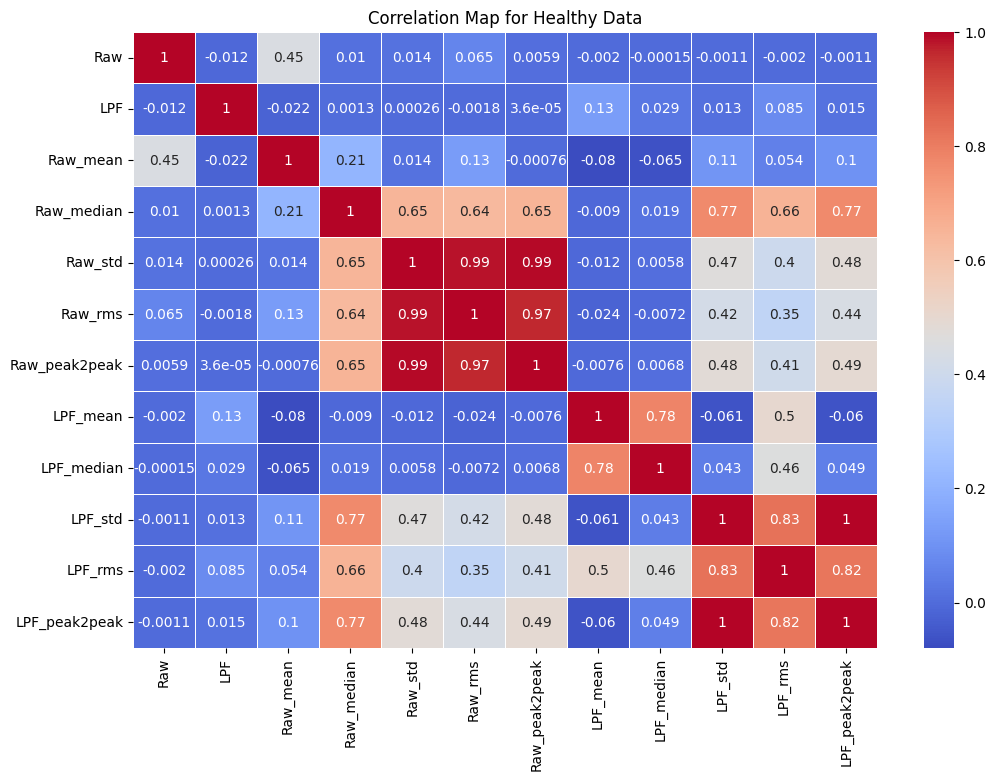

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(healthy_data_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for Healthy Data')
plt.show()

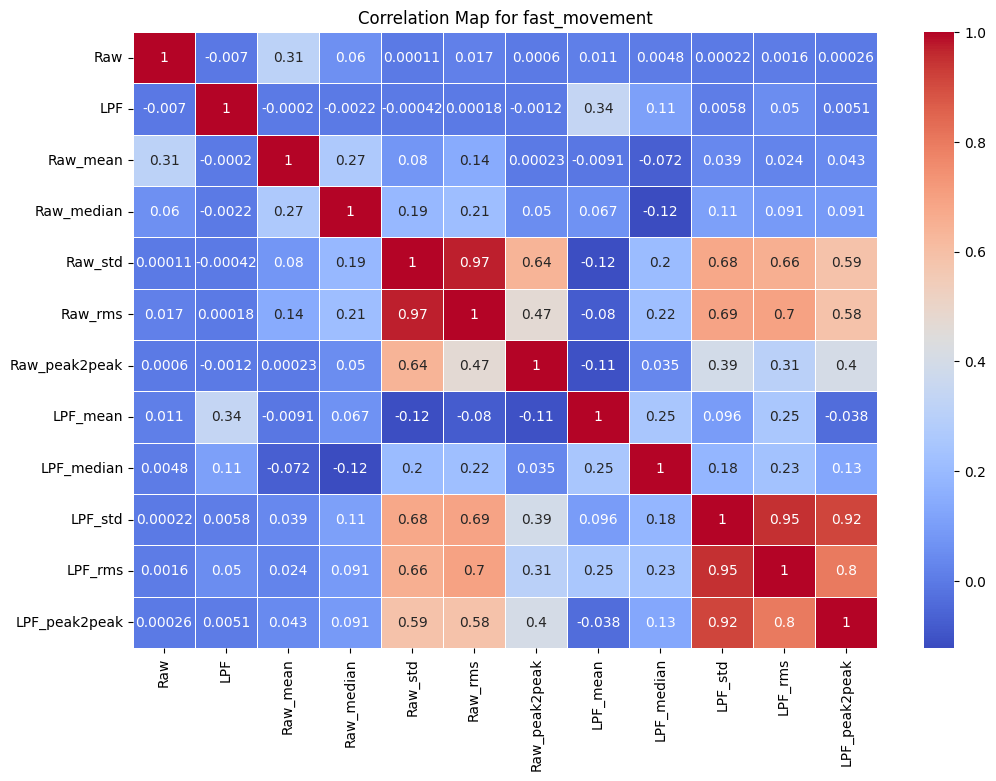

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(fast_data_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for fast_movement')
plt.show()

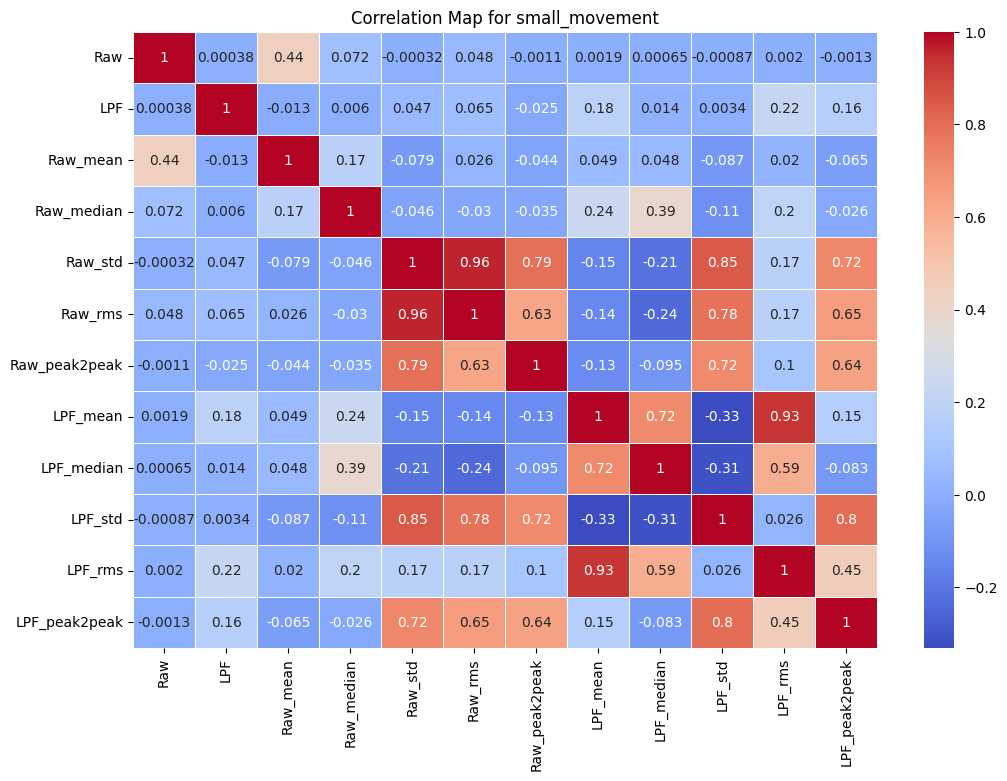

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(small_data_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for small_movement')
plt.show()

**Giving Labels for Training data**

In [ ]:
healthy_data_with_features_cleaned['label'] = 0
fast_data_with_features_cleaned['label'] = 1
small_data_with_features_cleaned['label'] = 2

<ipython-input-53-1e0d06bd6895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_data_with_features_cleaned['label'] = 0
<ipython-input-53-1e0d06bd6895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fast_data_with_features_cleaned['label'] = 1
<ipython-input-53-1e0d06bd6895>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

**Concatenating the Training data**

In [ ]:
train_data = pd.concat([healthy_data_with_features_cleaned,
                      fast_data_with_features_cleaned,
                      small_data_with_features_cleaned],
                     ignore_index=True)

In [ ]:
train_data.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak,label
0,2046,2042.161624,2049.200000,2048.0,3.563706,2049.202479,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
1,2048,2042.161624,2049.333333,2049.0,3.204164,2049.335421,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
2,2055,2042.161624,2047.714286,2048.0,5.186980,2047.719917,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
3,2050,2042.161624,2047.250000,2047.5,4.978525,2047.255297,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
4,2047,2042.161624,2046.333333,2047.0,5.408327,2046.339686,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0


**Loading the Test data**

In [ ]:
h_t1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/NMTestScan1.xlsx'), 'healthy')
h_t2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/NMTestScan2.xlsx'), 'healthy')

In [ ]:
i_t1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/FFTestScan1.xlsx'), 'fast_movement')
i_t2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/FFTestScan2.xlsx'), 'fast_movement')
i_t3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/SMTestscan1.xlsx'), 'small_movement')
i_t4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/SMTestScan2.xlsx'), 'small_movement')

**Concatenating the data according to their respective categories**

In [ ]:
h_t = pd.concat([h_t1, h_t2])
f_t= pd.concat([i_t1, i_t2])
s_t= pd.concat([i_t3, i_t4])

In [ ]:
h_t = preprocess_data(h_t)
f_t = preprocess_data(f_t)
s_t = preprocess_data(s_t)

In [ ]:
numeric_columns4 = h_t.select_dtypes(include=np.number).columns
numeric_columns5 = f_t.select_dtypes(include=np.number).columns
numeric_columns6 = s_t.select_dtypes(include=np.number).columns

**Extracting the features using fit transform function**

In [ ]:
h_t_aggregated_features = extractor.fit_transform(h_t[numeric_columns4])
f_t_aggregated_features = extractor.fit_transform(f_t[numeric_columns5])
s_t_aggregated_features = extractor.fit_transform(s_t[numeric_columns6])


**RESet the index**

In [ ]:
h_t_reset = h_t.reset_index(drop=True)
f_t_reset = f_t.reset_index(drop=True)
s_t_reset = s_t.reset_index(drop=True)

In [ ]:
h_t_aggregated_features_reset = h_t_aggregated_features.reset_index(drop=True)
f_t_aggregated_features_reset = f_t_aggregated_features.reset_index(drop=True)
s_t_aggregated_features_reset = s_t_aggregated_features.reset_index(drop=True)

**Concatenate the extracted features with its actual data**

In [ ]:
h_t_with_features = pd.concat([h_t_reset, h_t_aggregated_features_reset], axis=1)
f_t_with_features = pd.concat([f_t_reset, f_t_aggregated_features_reset], axis=1)
s_t_with_features = pd.concat([s_t_reset, s_t_aggregated_features_reset], axis=1)

In [ ]:
print("Healthy Data:")
print(h_t_with_features.head())

Healthy Data:
    Raw         LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  2767  2129.52124  2563.800000      2556.0  148.743739  2567.249540   
1  2644  2129.52124  2527.000000      2509.5  160.702209  2531.254630   
2  2556  2129.52124  2493.857143      2463.0  170.909751  2498.871888   
3  2463  2129.52124  2463.750000      2426.0  179.690806  2469.477020   
4  2389  2129.52124  2438.888889      2389.0  183.889535  2445.043376   

   Raw_peak2peak    LPF_mean  LPF_median  LPF_std     LPF_rms  LPF_peak2peak  
0          378.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
1          424.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
2          472.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
3          514.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
4          527.0  2129.52124  2129.52124      0.0  2129.52124            0.0  


In [ ]:
print("Fast Movement Data:")
print(f_t_with_features.head())

Fast Movement Data:
    Raw          LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  1999  2146.503174  1981.600000      1987.0  116.225212  1984.324873   
1  2162  2146.503174  1987.833333      1993.0  105.070294  1990.146016   
2  1987  2146.503174  1846.571429      1987.0  385.855265  1880.808641   
3  1864  2146.503174  1664.250000      1941.5  627.330797  1764.675324   
4  1896  2146.503174  1621.444444      1896.0  600.701072  1717.507011   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0          298.0  2146.503174  2146.503174      0.0  2146.503174   
1          298.0  2146.503174  2146.503174      0.0  2146.503174   
2         1163.0  2146.503174  2146.503174      0.0  2146.503174   
3         1774.0  2146.503174  2146.503174      0.0  2146.503174   
4         1774.0  2146.503174  2146.503174      0.0  2146.503174   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
print("Small Movement Data:")
print(s_t_with_features.head())

Small Movement Data:
    Raw          LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  4068  2125.338379  4065.600000      4069.0  15.598077  4065.623937   
1  4069  2125.338379  4066.500000      4070.0  14.124447  4066.520441   
2  4072  2125.338379  4068.428571      4071.0  13.866712  4068.448827   
3  4080  2125.338379  4069.000000      4071.5  12.939419  4069.018002   
4  4039  2125.338379  4069.777778      4072.0  12.326575  4069.794371   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0           41.0  2125.338379  2125.338379      0.0  2125.338379   
1           41.0  2125.338379  2125.338379      0.0  2125.338379   
2           41.0  2125.338379  2125.338379      0.0  2125.338379   
3           41.0  2125.338379  2125.338379      0.0  2125.338379   
4           41.0  2125.338379  2125.338379      0.0  2125.338379   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


**EDA ON HEALTHY TEST DATA**

In [ ]:
h_t_with_features.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,2767,2129.52124,2563.800000,2556.0,148.743739,2567.249540,378.0,2129.52124,2129.52124,0.0,2129.52124,0.0
1,2644,2129.52124,2527.000000,2509.5,160.702209,2531.254630,424.0,2129.52124,2129.52124,0.0,2129.52124,0.0
2,2556,2129.52124,2493.857143,2463.0,170.909751,2498.871888,472.0,2129.52124,2129.52124,0.0,2129.52124,0.0
3,2463,2129.52124,2463.750000,2426.0,179.690806,2469.477020,514.0,2129.52124,2129.52124,0.0,2129.52124,0.0
4,2389,2129.52124,2438.888889,2389.0,183.889535,2445.043376,527.0,2129.52124,2129.52124,0.0,2129.52124,0.0


In [ ]:
h_t_with_features.shape

(7230, 12)

In [ ]:
h_t_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7230 entries, 0 to 7229
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7230 non-null   int64  
 1   LPF            7230 non-null   float64
 2   Raw_mean       7226 non-null   float64
 3   Raw_median     7226 non-null   float64
 4   Raw_std        7226 non-null   float64
 5   Raw_rms        7226 non-null   float64
 6   Raw_peak2peak  7226 non-null   float64
 7   LPF_mean       7226 non-null   float64
 8   LPF_median     7226 non-null   float64
 9   LPF_std        7226 non-null   float64
 10  LPF_rms        7226 non-null   float64
 11  LPF_peak2peak  7226 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 677.9 KB


In [ ]:
h_t_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
h_t_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
h_t_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
h_t_with_features_cleaned = h_t_with_features.dropna()

In [ ]:
print(h_t_with_features_cleaned.head())

    Raw         LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  2767  2129.52124  2563.800000      2556.0  148.743739  2567.249540   
1  2644  2129.52124  2527.000000      2509.5  160.702209  2531.254630   
2  2556  2129.52124  2493.857143      2463.0  170.909751  2498.871888   
3  2463  2129.52124  2463.750000      2426.0  179.690806  2469.477020   
4  2389  2129.52124  2438.888889      2389.0  183.889535  2445.043376   

   Raw_peak2peak    LPF_mean  LPF_median  LPF_std     LPF_rms  LPF_peak2peak  
0          378.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
1          424.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
2          472.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
3          514.0  2129.52124  2129.52124      0.0  2129.52124            0.0  
4          527.0  2129.52124  2129.52124      0.0  2129.52124            0.0  


In [ ]:
h_t_with_features['Raw'].nunique()

245

In [ ]:
for i in h_t_with_features.columns:
    print(i)
    print(h_t_with_features[i].nunique())
    print(h_t_with_features[i].unique())

Raw
245
[2767 2644 2556 2463 2389 2343 2295 2253 2240 2223 2209 2189 2175 2158
 2154 2125 2115 2112 2108 2104 2103 2093 2100 2082 2085 2090 2088 2087
 2101 2086 2089 2083 2081 2073 2078 2084 2071 2068 2059 2075 2069 2079
 2065 2080 2077 2063 2072 2050 2042 2052 2049 2070 2076 2096 2048 2045
 2036 2058 2060 2057 2051 2064 2067 2066 2056 2053 2054 2062 2047 2055
 2046 2035 2074 2040 2041 2044 2043 2039 2037 2027 2033 2061 2038 2019
 2032 2025 2021 2028 2034 2030 2026 2020 2029 2031 2024 2023 2016 2022
 2010 2011 2018 2095 2013 1999 2017 2012 2003 2132 2172 2208 2216 2162
 2113 2014 1969 1951 1953 1944 1950 1960 1972 2008 1995 2002 2007 2015
 1975 1958 1943 1948 1956 1982 1978 1976 1952 1962 1967 1970 1993 2004
 2005 1997 2110 2124 2135 2143 2145 2136 2131 2122 2097 2434 2373 2322
 2281 2226 2211 2191 2194 2180 2160 2149 2119 2120 2129 2111 2116 2099
 2098 2094 2105 2091 2102 2106 2107 2092 2121 2144 2156 2140 1961 1968
 1963 1994 1955 1949 1964 1984 2161 2168 2166 2148 2123 2109 2006 198

**EDA ON FAST MOVEMENT DATA**

In [ ]:
f_t_with_features.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,1999,2146.503174,1981.600000,1987.0,116.225212,1984.324873,298.0,2146.503174,2146.503174,0.0,2146.503174,0.0
1,2162,2146.503174,1987.833333,1993.0,105.070294,1990.146016,298.0,2146.503174,2146.503174,0.0,2146.503174,0.0
2,1987,2146.503174,1846.571429,1987.0,385.855265,1880.808641,1163.0,2146.503174,2146.503174,0.0,2146.503174,0.0
3,1864,2146.503174,1664.250000,1941.5,627.330797,1764.675324,1774.0,2146.503174,2146.503174,0.0,2146.503174,0.0
4,1896,2146.503174,1621.444444,1896.0,600.701072,1717.507011,1774.0,2146.503174,2146.503174,0.0,2146.503174,0.0


In [ ]:
f_t_with_features.shape

(7361, 12)

In [ ]:
f_t_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7361 entries, 0 to 7360
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7361 non-null   int64  
 1   LPF            7361 non-null   float64
 2   Raw_mean       7357 non-null   float64
 3   Raw_median     7357 non-null   float64
 4   Raw_std        7357 non-null   float64
 5   Raw_rms        7357 non-null   float64
 6   Raw_peak2peak  7357 non-null   float64
 7   LPF_mean       7357 non-null   float64
 8   LPF_median     7357 non-null   float64
 9   LPF_std        7357 non-null   float64
 10  LPF_rms        7357 non-null   float64
 11  LPF_peak2peak  7357 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 690.2 KB


In [ ]:
f_t_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
f_t_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
f_t_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
f_t_with_features_cleaned = f_t_with_features.dropna()


In [ ]:
print("Fast Movement Data (Cleaned):")
print(f_t_with_features_cleaned.head())

Fast Movement Data (Cleaned):
    Raw          LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  1999  2146.503174  1981.600000      1987.0  116.225212  1984.324873   
1  2162  2146.503174  1987.833333      1993.0  105.070294  1990.146016   
2  1987  2146.503174  1846.571429      1987.0  385.855265  1880.808641   
3  1864  2146.503174  1664.250000      1941.5  627.330797  1764.675324   
4  1896  2146.503174  1621.444444      1896.0  600.701072  1717.507011   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0          298.0  2146.503174  2146.503174      0.0  2146.503174   
1          298.0  2146.503174  2146.503174      0.0  2146.503174   
2         1163.0  2146.503174  2146.503174      0.0  2146.503174   
3         1774.0  2146.503174  2146.503174      0.0  2146.503174   
4         1774.0  2146.503174  2146.503174      0.0  2146.503174   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
f_t_with_features['Raw'].nunique()

1593

In [ ]:
for i in f_t_with_features.columns:
    print(i)
    print(f_t_with_features[i].nunique())
    print(f_t_with_features[i].unique())

Raw
1593
[1999 2162 1987 ... 1368  988  955]
LPF
6914
[2146.50317383 1850.75       2545.63989258 ... 2113.08007812 1970.43994141
 1924.48999023]
Raw_mean
4550
[1981.6        1987.83333333 1846.57142857 ... 2047.79       2045.08
           nan]
Raw_median
156
[1987.  1993.  1941.5 1896.  1999.  2009.  2019.  2090.5 2062.5 2106.
 2134.  1974.5 1962.  1930.  1905.  1933.5 1940.5 1919.  1912.  1952.
 2007.5 2016.  2006.  2013.  2014.5 2017.5 2022.  2025.  2032.5 2040.
 2040.5 2041.  2048.  2055.  2031.  2035.5 2055.5 2056.  2059.  2062.
 2066.  2070.  2070.5 2071.  2072.  2051.5 2057.  2058.  2060.  2044.5
 2046.  2044.  2043.  2042.  2041.5 2037.5 2056.5 2048.5 2052.  2053.5
 2057.5 2050.5 2043.5 2042.5 2046.5 2049.5 2051.  2050.  2061.  2061.5
 2063.  2064.  2058.5 2052.5 2049.  2047.  2045.  2039.  2038.5 2038.
 2037.  2036.5 2034.5 2033.5 2033.  2030.  2029.5 2025.5 2023.  2021.5
 2020.5 2018.  2021.  2024.5 2027.5 2030.5 2015.5 2014.  2011.5 2010.5
 2039.5 2054.  2054.5 2047.5 2053.  

In [ ]:
f_t_with_features['Raw'].value_counts()

2048    21
2055    20
1976    19
2050    18
1943    18
        ..
1250     1
3118     1
3292     1
3048     1
955      1
Name: Raw, Length: 1593, dtype: int64

In [ ]:
f_t_with_features['Raw'].describe()

count    7361.000000
mean     2047.421682
std       345.134054
min       388.000000
25%      1844.000000
50%      2048.000000
75%      2249.000000
max      3638.000000
Name: Raw, dtype: float64

In [ ]:
s_t_with_features.head()


,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak
0,4068,2125.338379,4065.600000,4069.0,15.598077,4065.623937,41.0,2125.338379,2125.338379,0.0,2125.338379,0.0
1,4069,2125.338379,4066.500000,4070.0,14.124447,4066.520441,41.0,2125.338379,2125.338379,0.0,2125.338379,0.0
2,4072,2125.338379,4068.428571,4071.0,13.866712,4068.448827,41.0,2125.338379,2125.338379,0.0,2125.338379,0.0
3,4080,2125.338379,4069.000000,4071.5,12.939419,4069.018002,41.0,2125.338379,2125.338379,0.0,2125.338379,0.0
4,4039,2125.338379,4069.777778,4072.0,12.326575,4069.794371,41.0,2125.338379,2125.338379,0.0,2125.338379,0.0


**EDA ON SMALL MOVEMENT TEST DATA**

In [ ]:
s_t_with_features.shape

(7601, 12)

In [ ]:
s_t_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601 entries, 0 to 7600
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7601 non-null   int64  
 1   LPF            7601 non-null   float64
 2   Raw_mean       7597 non-null   float64
 3   Raw_median     7597 non-null   float64
 4   Raw_std        7597 non-null   float64
 5   Raw_rms        7597 non-null   float64
 6   Raw_peak2peak  7597 non-null   float64
 7   LPF_mean       7597 non-null   float64
 8   LPF_median     7597 non-null   float64
 9   LPF_std        7597 non-null   float64
 10  LPF_rms        7597 non-null   float64
 11  LPF_peak2peak  7597 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 712.7 KB


In [ ]:
s_t_with_features.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak'],
      dtype='object')

In [ ]:
s_t_with_features.dtypes

Raw                int64
LPF              float64
Raw_mean         float64
Raw_median       float64
Raw_std          float64
Raw_rms          float64
Raw_peak2peak    float64
LPF_mean         float64
LPF_median       float64
LPF_std          float64
LPF_rms          float64
LPF_peak2peak    float64
dtype: object

In [ ]:
s_t_with_features.isnull().sum()

Raw              0
LPF              0
Raw_mean         4
Raw_median       4
Raw_std          4
Raw_rms          4
Raw_peak2peak    4
LPF_mean         4
LPF_median       4
LPF_std          4
LPF_rms          4
LPF_peak2peak    4
dtype: int64

In [ ]:
s_t_with_features_cleaned = s_t_with_features.dropna()

In [ ]:
print(s_t_with_features_cleaned.head())

    Raw          LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  4068  2125.338379  4065.600000      4069.0  15.598077  4065.623937   
1  4069  2125.338379  4066.500000      4070.0  14.124447  4066.520441   
2  4072  2125.338379  4068.428571      4071.0  13.866712  4068.448827   
3  4080  2125.338379  4069.000000      4071.5  12.939419  4069.018002   
4  4039  2125.338379  4069.777778      4072.0  12.326575  4069.794371   

   Raw_peak2peak     LPF_mean   LPF_median  LPF_std      LPF_rms  \
0           41.0  2125.338379  2125.338379      0.0  2125.338379   
1           41.0  2125.338379  2125.338379      0.0  2125.338379   
2           41.0  2125.338379  2125.338379      0.0  2125.338379   
3           41.0  2125.338379  2125.338379      0.0  2125.338379   
4           41.0  2125.338379  2125.338379      0.0  2125.338379   

   LPF_peak2peak  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [ ]:
s_t_with_features['Raw'].nunique()

2766

In [ ]:
for i in s_t_with_features.columns:
    print(i)
    print(s_t_with_features[i].nunique())
    print(s_t_with_features[i].unique())

Raw
2766
[4068 4069 4072 ... 2324 2408 2475]
LPF
7251
[2125.33837891 1800.33996582 2489.5        ... 1275.26000977  756.2800293
  264.01000977]
Raw_mean
6915
[4065.6        4066.5        4068.42857143 ... 2038.242      2037.124
           nan]
Raw_median
657
[4069.  4070.  4071.  4071.5 4072.  4072.5 4068.5 4068.  4066.5 4065.
 4064.  4063.  4062.  4061.  4059.5 4058.  4056.  4054.  4052.5 4051.
 4049.  4047.  4046.5 4046.  4044.5 4043.  4042.  4041.  4040.  4039.
 4038.5 4038.  4036.5 4035.  4039.5 4034.  4033.  4032.  4031.  4030.5
 4030.  4010.  3990.  3976.5 3963.  3939.5 3916.  3866.5 3817.  3788.
 3759.  3755.5 3752.  3691.5 3913.5 3911.  3864.  3631.  3505.  3379.
 3360.  3341.  3335.5 3330.  3306.  3282.  3272.5 3263.  3496.5 3614.
 3622.5 3534.  3454.  3416.5 3206.  3149.  3141.5 3316.5 3303.  3292.5
 3259.5 3256.  3241.5 3227.  3188.  3142.  3135.  3134.5 3134.  3248.
 3240.  3233.5 3122.  3110.  3104.5 3099.  3098.  3097.  3095.5 3094.
 3089.  3084.  3055.  3026.  3012.  299

In [ ]:
s_t_with_features['Raw'].value_counts()

0       1365
4071     123
4072     120
4076     106
4074     100
        ... 
2520       1
1131       1
524        1
60         1
2475       1
Name: Raw, Length: 2766, dtype: int64

In [ ]:
s_t_with_features['Raw'].describe()

count    7601.000000
mean     2057.960268
std      1539.465556
min         0.000000
25%       433.000000
50%      2068.000000
75%      3690.000000
max      4088.000000
Name: Raw, dtype: float64

**CORRELATION MAPS FOR VISUALISING THE FEATURE IMPORTANCE**

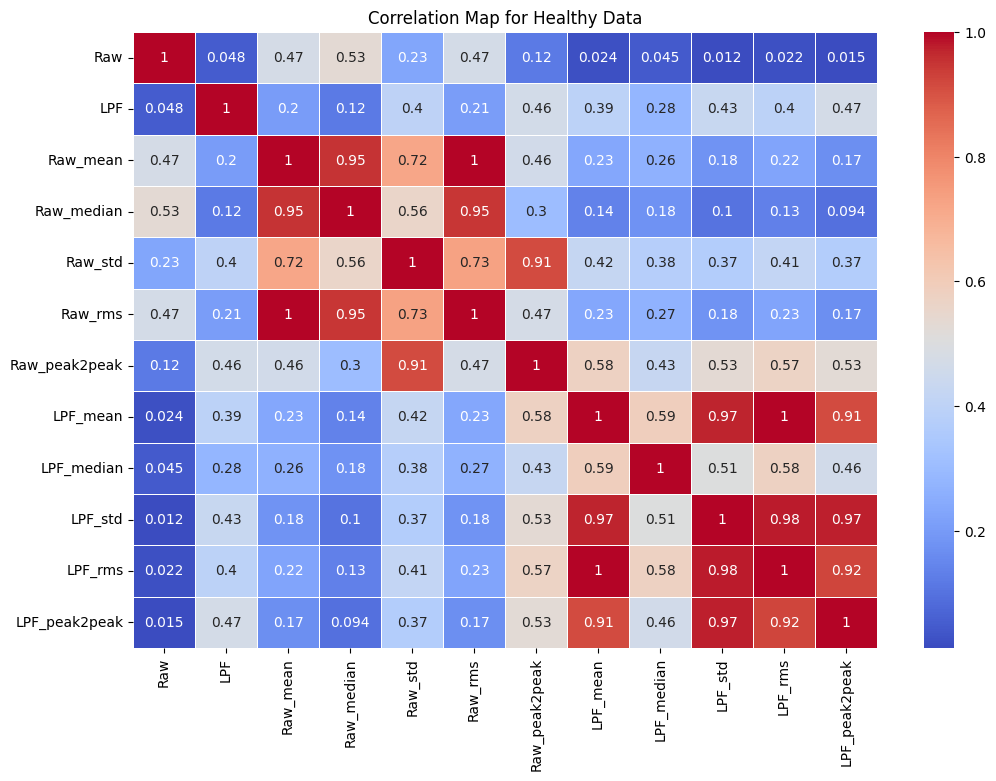

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(h_t_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for Healthy Data')
plt.show()

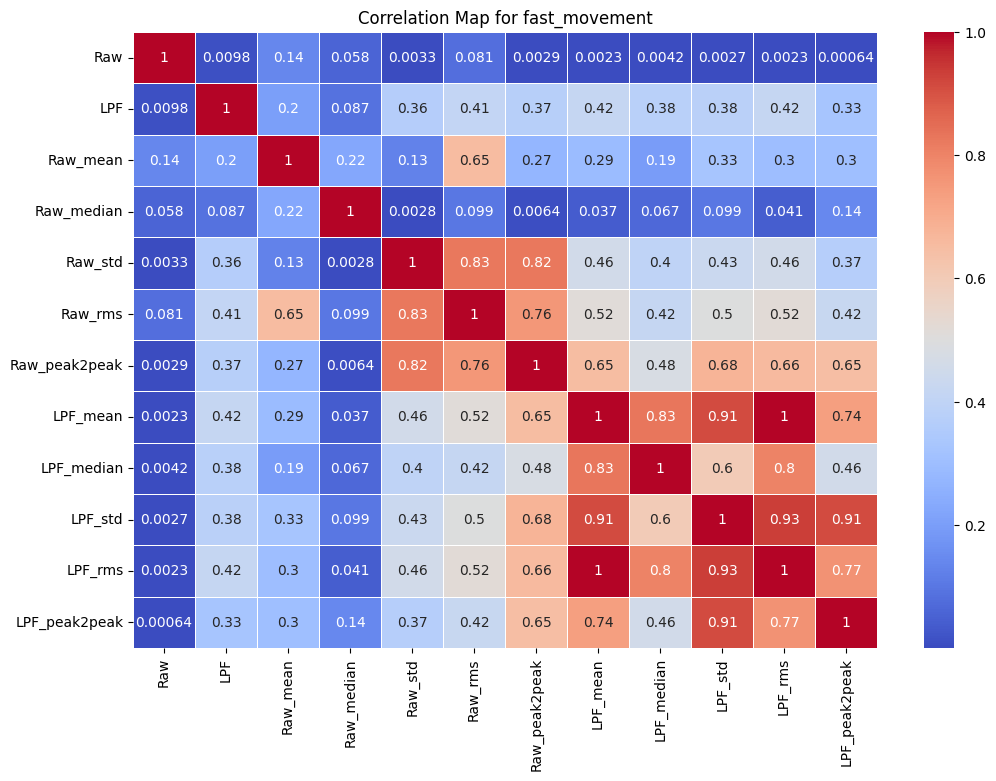

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(f_t_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for fast_movement')
plt.show()

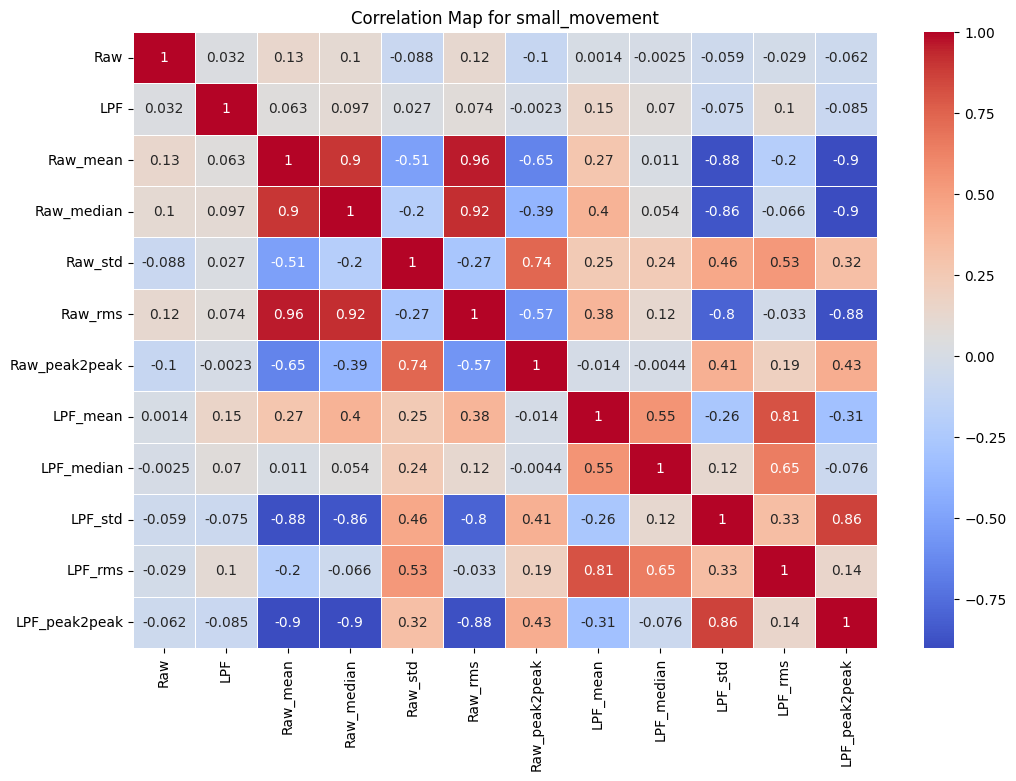

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(s_t_with_features.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map for small_movement')
plt.show()

**Labeling the data**

In [ ]:
h_t_with_features_cleaned['label'] = 0
f_t_with_features_cleaned['label'] = 1
s_t_with_features_cleaned['label'] = 2

<ipython-input-105-011a9ce89860>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_t_with_features_cleaned['label'] = 0
<ipython-input-105-011a9ce89860>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_t_with_features_cleaned['label'] = 1
<ipython-input-105-011a9ce89860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

**Concatenating all teh test data**

In [ ]:
test_data = pd.concat([h_t_with_features_cleaned,
                      f_t_with_features_cleaned,
                      s_t_with_features_cleaned],
                     ignore_index=True)

In [ ]:
test_data.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak,label
0,2767,2129.52124,2563.800000,2556.0,148.743739,2567.249540,378.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
1,2644,2129.52124,2527.000000,2509.5,160.702209,2531.254630,424.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
2,2556,2129.52124,2493.857143,2463.0,170.909751,2498.871888,472.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
3,2463,2129.52124,2463.750000,2426.0,179.690806,2469.477020,514.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
4,2389,2129.52124,2438.888889,2389.0,183.889535,2445.043376,527.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0


In [ ]:
test_data.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak', 'label'],
      dtype='object')

In [ ]:
train_data.shape

(50456, 13)

In [ ]:
test_data.shape

(22180, 13)

**SELECTED FEATURES**

In [ ]:
selected_features = [ 'Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']

**Giving Values to do trsin test split**

In [ ]:
X_train = train_data[selected_features]
y_train = train_data['label']
X_test = test_data[selected_features]
y_test = test_data['label']

**TRAIN TEST SPLIT**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ])

**DEFINING FUNCTION TO TRAIN AND EVALUATE THE MODELS**

In [ ]:
def train_and_evaluate(model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train_resampled, y_train_resampled)

    # For Validation Set
    y_val_pred_probs = pipeline.predict_proba(X_val)
    print(f"{type(model).__name__} Validation Predicted Probabilities:\n{y_val_pred_probs}")

    y_val_pred = pipeline.predict(X_val)
    print(f"{type(model).__name__} Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
    print(f"{type(model).__name__} Validation Classification Report:\n{classification_report(y_val, y_val_pred)}")

    # For Test Set
    y_test_pred_probs = pipeline.predict_proba(X_test)
    print(f"{type(model).__name__} Test Predicted Probabilities:\n{y_test_pred_probs}")

    y_test_pred = pipeline.predict(X_test)
    print(f"{type(model).__name__} Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"{type(model).__name__} Test Classification Report:\n{classification_report(y_test, y_test_pred)}")

    return pipeline

**Using the function on models**

In [ ]:
# Train and evaluate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipeline = train_and_evaluate(rf_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)

# For Validation Set
y_val_pred_probs = rf_pipeline.predict_proba(X_val)
print(f"{type(rf_model).__name__} Validation Predicted Probabilities:\n{y_val_pred_probs}")

# For Test Set
y_test_pred_probs = rf_pipeline.predict_proba(X_test)
print(f"{type(rf_model).__name__} Test Predicted Probabilities:\n{y_test_pred_probs}")

RandomForestClassifier Validation Predicted Probabilities:
[[0.   0.   1.  ]
 [0.   0.   1.  ]
 [1.   0.   0.  ]
 ...
 [1.   0.   0.  ]
 [0.   0.99 0.01]
 [1.   0.   0.  ]]
RandomForestClassifier Validation Accuracy: 0.9997027348394768
RandomForestClassifier Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3217
           1       1.00      1.00      1.00      3237
           2       1.00      1.00      1.00      3638

    accuracy                           1.00     10092
   macro avg       1.00      1.00      1.00     10092
weighted avg       1.00      1.00      1.00     10092

RandomForestClassifier Test Predicted Probabilities:
[[0.16 0.65 0.19]
 [0.16 0.65 0.19]
 [0.16 0.65 0.19]
 ...
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   0.   1.  ]]
RandomForestClassifier Test Accuracy: 0.8509017132551848
RandomForestClassifier Test Classification Report:
              precision    recall  f1-score   suppo

In [ ]:
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_pipeline = train_and_evaluate(logreg_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)


LogisticRegression Validation Predicted Probabilities:
[[1.19773669e-03 2.15237822e-01 7.83564441e-01]
 [1.54871199e-05 9.30154727e-02 9.06969040e-01]
 [9.53312249e-01 2.45201991e-02 2.21675522e-02]
 ...
 [9.28343136e-01 3.90867129e-02 3.25701513e-02]
 [8.36872783e-04 9.18949815e-01 8.02133126e-02]
 [9.52414907e-01 2.49754705e-02 2.26096225e-02]]
LogisticRegression Validation Accuracy: 0.8938763376932224
LogisticRegression Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3217
           1       0.85      0.87      0.86      3237
           2       0.91      0.85      0.88      3638

    accuracy                           0.89     10092
   macro avg       0.89      0.90      0.89     10092
weighted avg       0.89      0.89      0.89     10092

LogisticRegression Test Predicted Probabilities:
[[9.99840029e-01 1.15585674e-04 4.43851852e-05]
 [9.99832845e-01 1.23732200e-04 4.34223887e-05]
 [9.99824744e

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_pipeline = train_and_evaluate(dt_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)


DecisionTreeClassifier Validation Predicted Probabilities:
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
DecisionTreeClassifier Validation Accuracy: 0.9990091161315894
DecisionTreeClassifier Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3217
           1       1.00      1.00      1.00      3237
           2       1.00      1.00      1.00      3638

    accuracy                           1.00     10092
   macro avg       1.00      1.00      1.00     10092
weighted avg       1.00      1.00      1.00     10092

DecisionTreeClassifier Test Predicted Probabilities:
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
DecisionTreeClassifier Test Accuracy: 0.7756086564472497
DecisionTreeClassifier Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      7226
           1  

In [ ]:
svm_model = SVC(probability=True, random_state=42)
svm_pipeline = train_and_evaluate(svm_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)


SVC Validation Predicted Probabilities:
[[8.06247291e-05 1.15952169e-02 9.88324158e-01]
 [5.99660922e-05 1.10581248e-02 9.88881909e-01]
 [9.56552060e-01 1.66248655e-03 4.17854532e-02]
 ...
 [8.88845546e-01 6.94140377e-02 4.17404161e-02]
 [9.86216503e-05 9.88939703e-01 1.09616754e-02]
 [9.56903015e-01 1.60203672e-03 4.14949487e-02]]
SVC Validation Accuracy: 0.9363852556480381
SVC Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3217
           1       0.93      0.92      0.92      3237
           2       0.94      0.90      0.92      3638

    accuracy                           0.94     10092
   macro avg       0.94      0.94      0.94     10092
weighted avg       0.94      0.94      0.94     10092

SVC Test Predicted Probabilities:
[[2.32397228e-01 2.10017836e-01 5.57584936e-01]
 [2.18750424e-01 2.18594565e-01 5.62655011e-01]
 [2.05334119e-01 2.26533189e-01 5.68132692e-01]
 ...
 [3.04070410e-03 2.0

In [ ]:
keras_model = Sequential()
keras_model.add(Dense(units=128, activation='relu', input_dim=X_train_resampled.shape[1]))
keras_model.add(Dense(units=3, activation='softmax'))
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tf2onnx

**Defining the function to train and evaluate Keras model**

In [ ]:
def train_and_evaluate(model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train_resampled, y_train_resampled)

    # For Validation Set
    y_val_pred_probs = pipeline.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)
    print(f"{type(model).__name__} Validation Predicted Probabilities:\n{y_val_pred_probs}")

    print(f"{type(model).__name__} Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
    print(f"{type(model).__name__} Validation Classification Report:\n{classification_report(y_val, y_val_pred)}")

    # For Test Set
    y_test_pred_probs = pipeline.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)
    print(f"{type(model).__name__} Test Predicted Probabilities:\n{y_test_pred_probs}")

    print(f"{type(model).__name__} Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"{type(model).__name__} Test Classification Report:\n{classification_report(y_test, y_test_pred)}")

    return pipeline

In [ ]:
keras_pipeline = train_and_evaluate(keras_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)

316/316 [==============================] - 1s 2ms/step
Sequential Validation Predicted Probabilities:
[[5.9288839e-04 1.3995661e-01 8.5945046e-01]
 [1.0765094e-03 8.7997571e-02 9.1092604e-01]
 [9.5472527e-01 1.6738748e-02 2.8536033e-02]
 ...
 [8.8959891e-01 5.4578818e-02 5.5822320e-02]
 [1.2186106e-03 9.5593220e-01 4.2849179e-02]
 [9.5499432e-01 1.6566329e-02 2.8439334e-02]]
Sequential Validation Accuracy: 0.9030915576694412
Sequential Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3217
           1       0.86      0.91      0.88      3237
           2       0.94      0.84      0.89      3638

    accuracy                           0.90     10092
   macro avg       0.90      0.91      0.90     10092
weighted avg       0.90      0.90      0.90     10092

694/694 [==============================] - 1s 2ms/step
Sequential Test Predicted Probabilities:
[[9.2970115e-01 4.2910218e-02 2.7388571e-02]
 [9.

In [ ]:
print(X_train.shape[1])

5


**Converting the models to ONXX and ORT**

In [ ]:
def convert_to_onnx(model, X, onnx_path, input_names=None):
    if input_names is None:
        input_names = list(X.columns)

    # Convert input names to ONNX-compatible format
    initial_type = [(name, FloatTensorType([None, 1])) for name in input_names]

    onnx_model = convert_sklearn(model, initial_types=initial_type)

    with open(onnx_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())


In [ ]:
convert_to_onnx(rf_pipeline, X_test, 'rf_model.onnx', input_names=selected_features)
rf_ort_model = ort.InferenceSession('rf_model.onnx')

**Evaluating the ort model**

In [ ]:
def evaluate_onnx_model(model, X_test, selected_features):
    input_names = [input.name for input in model.get_inputs()]
    print(f"Expected input names for the model: {input_names}")

    # Get predicted probabilities using ONNX model
    ort_predictions_list = model.run(None, {input_names[i]: X_test[selected_features].iloc[:, i].values.astype(np.float32)[:, None] for i in range(len(input_names))})

    # Assuming ort_predictions_list contains only two elements
    # Extract the probabilities directly
    probabilities = ort_predictions_list[1]

    # Check if probabilities is a list and convert it to a NumPy array
    if isinstance(probabilities, list):
        probabilities = np.array([list(sample.values()) for sample in probabilities])

    # Check if probabilities is a 1D array and add a second dimension
    if len(probabilities.shape) == 1:
        probabilities = probabilities[:, None]

    # Find the class label corresponding to the highest probability for each sample
    ort_predicted_labels = np.argmax(probabilities, axis=1)

    # Print the predicted labels
    print("Predicted Labels based on Highest Probabilities:")
    print(ort_predicted_labels)

    # Print raw probabilities for the first few samples
    for i in range(min(5, len(probabilities))):
        print(f"Raw Probabilities for Sample {i}: {probabilities[i]}")

    # Calculate accuracy
    ort_accuracy_prob = accuracy_score(y_test, ort_predicted_labels)
    print(f"ONNX Model Accuracy using Predicted Labels: {ort_accuracy_prob}")


In [ ]:
evaluate_onnx_model(rf_ort_model, X_test, selected_features)

Expected input names for the model: ['Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']
Predicted Labels based on Highest Probabilities:
[1 1 1 ... 2 2 2]
Raw Probabilities for Sample 0: [0.16       0.64999968 0.19000001]
Raw Probabilities for Sample 1: [0.16       0.64999968 0.19000001]
Raw Probabilities for Sample 2: [0.16       0.64999968 0.19000001]
Raw Probabilities for Sample 3: [0.10999998 0.53999978 0.34999993]
Raw Probabilities for Sample 4: [0.10999998 0.53999978 0.34999993]
ONNX Model Accuracy using Predicted Labels: 0.8510820559062218


**Printing Random forest predictions and Accuracy**

**Converting logistic regression model to ort model**

In [ ]:
convert_to_onnx(logreg_pipeline, X_test, 'logreg_model.onnx', input_names=selected_features)
logreg_ort_model = ort.InferenceSession('logreg_model.onnx')

In [ ]:
evaluate_onnx_model(logreg_ort_model, X_test, selected_features)

Expected input names for the model: ['Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']
Predicted Labels based on Highest Probabilities:
[0 0 0 ... 2 2 2]
Raw Probabilities for Sample 0: [9.99840021e-01 1.15585281e-04 4.43849785e-05]
Raw Probabilities for Sample 1: [9.99832869e-01 1.23731850e-04 4.34221583e-05]
Raw Probabilities for Sample 2: [9.99824762e-01 1.32507295e-04 4.27479245e-05]
Raw Probabilities for Sample 3: [9.99817193e-01 1.40670978e-04 4.21867662e-05]
Raw Probabilities for Sample 4: [9.99814689e-01 1.43536512e-04 4.18168274e-05]
ONNX Model Accuracy using Predicted Labels: 0.8912533814247069


**Converting Decision tree model to ort model**

In [ ]:
convert_to_onnx(dt_pipeline, X_test, 'dt_model.onnx', input_names=selected_features)
dt_ort_model = ort.InferenceSession('dt_model.onnx')

In [ ]:
evaluate_onnx_model(dt_ort_model, X_test, selected_features)

Expected input names for the model: ['Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']
Predicted Labels based on Highest Probabilities:
[1 1 1 ... 2 2 2]
Raw Probabilities for Sample 0: [0. 1. 0.]
Raw Probabilities for Sample 1: [0. 1. 0.]
Raw Probabilities for Sample 2: [0. 1. 0.]
Raw Probabilities for Sample 3: [0. 0. 1.]
Raw Probabilities for Sample 4: [0. 0. 1.]
ONNX Model Accuracy using Predicted Labels: 0.7756086564472497


**Converting svm model to ort model**

In [ ]:
convert_to_onnx(svm_pipeline, X_test, 'svm_model.onnx', input_names=selected_features)
svm_ort_model = ort.InferenceSession('svm_model.onnx')

In [ ]:
evaluate_onnx_model(svm_ort_model, X_test, selected_features)

Expected input names for the model: ['Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']
Predicted Labels based on Highest Probabilities:
[2 2 2 ... 2 2 2]
Raw Probabilities for Sample 0: [0.23239681 0.21001628 0.55758697]
Raw Probabilities for Sample 1: [0.21874881 0.21859106 0.56266022]
Raw Probabilities for Sample 2: [0.20533472 0.22653252 0.56813276]
Raw Probabilities for Sample 3: [0.19334795 0.23510017 0.57155174]
Raw Probabilities for Sample 4: [0.18894605 0.2409319  0.570122  ]
ONNX Model Accuracy using Predicted Labels: 0.8586113615870153
